# Import Section

In [1]:
import findspark
findspark.init()

In [2]:
import pyspark
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pyspark.sql.functions as func
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler, StandardScaler, RobustScaler
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.regression import LinearRegression

In [3]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12,8]

# Start Spark Session

In [4]:
spark = SparkSession.builder.appName("Linear_Regression").getOrCreate()

In [5]:
sc = spark.sparkContext

In [6]:
sc

<SparkContext master=local[*] appName=Linear_Regression>

# Load CSV file ("Dataset_Voli")

In [7]:
dsname = "Dataset_Voli.csv"
dspath = "C:\\Users\\Francesco\Desktop\LABORATORIO DI BIG DATA"

In [8]:
df = spark.read.csv(os.path.join(dspath,dsname), inferSchema=True, header=True)

# Overview of Dataset

In [9]:
df.count()

300153

In [10]:
len(df.columns)

12

In [11]:
df.head()

Row(_c0=0, airline='SpiceJet', flight='SG-8709', source_city='Delhi', departure_time='Evening', stops='zero', arrival_time='Night', destination_city='Mumbai', class='Economy', duration=2.17, days_left=1, price=5953)

In [12]:
df.tail(1)

[Row(_c0=300152, airline='Vistara', flight='UK-822', source_city='Chennai', departure_time='Morning', stops='one', arrival_time='Evening', destination_city='Hyderabad', class='Business', duration=10.08, days_left=49, price=81585)]

In [13]:
df.show()

+---+---------+-------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-----+
|_c0|  airline| flight|source_city|departure_time|stops| arrival_time|destination_city|  class|duration|days_left|price|
+---+---------+-------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-----+
|  0| SpiceJet|SG-8709|      Delhi|       Evening| zero|        Night|          Mumbai|Economy|    2.17|        1| 5953|
|  1| SpiceJet|SG-8157|      Delhi| Early_Morning| zero|      Morning|          Mumbai|Economy|    2.33|        1| 5953|
|  2|  AirAsia| I5-764|      Delhi| Early_Morning| zero|Early_Morning|          Mumbai|Economy|    2.17|        1| 5956|
|  3|  Vistara| UK-995|      Delhi|       Morning| zero|    Afternoon|          Mumbai|Economy|    2.25|        1| 5955|
|  4|  Vistara| UK-963|      Delhi|       Morning| zero|      Morning|          Mumbai|Economy|    2.33|        1| 5955|
|  5|  Vistara| UK-945|      Del

In [14]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- airline: string (nullable = true)
 |-- flight: string (nullable = true)
 |-- source_city: string (nullable = true)
 |-- departure_time: string (nullable = true)
 |-- stops: string (nullable = true)
 |-- arrival_time: string (nullable = true)
 |-- destination_city: string (nullable = true)
 |-- class: string (nullable = true)
 |-- duration: double (nullable = true)
 |-- days_left: integer (nullable = true)
 |-- price: integer (nullable = true)



# Data Cleaning:

## Cleaning of NA values,Duplicates values and control of useless values

In [15]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+-------+------+-----------+--------------+-----+------------+----------------+-----+--------+---------+-----+
|_c0|airline|flight|source_city|departure_time|stops|arrival_time|destination_city|class|duration|days_left|price|
+---+-------+------+-----------+--------------+-----+------------+----------------+-----+--------+---------+-----+
|  0|      0|     0|          0|             0|    0|           0|               0|    0|       0|        0|    0|
+---+-------+------+-----------+--------------+-----+------------+----------------+-----+--------+---------+-----+



In [16]:
df = df.distinct()
print("Distinct count: "+str(df.count()))

Distinct count: 300153


In [17]:
df = df.drop("_c0")
df = df.drop("flight")
len(df.columns)

10

# Casting and Recoding

In [18]:
df = df.withColumn("duration", func.round(df["duration"]).cast('integer'))
df.show()
df.printSchema()

+---------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-----+
|  airline|source_city|departure_time|stops| arrival_time|destination_city|  class|duration|days_left|price|
+---------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+-----+
|Air_India|      Delhi|         Night|  one|      Morning|          Mumbai|Economy|      11|        3|12150|
|Air_India|      Delhi| Early_Morning|  one|    Afternoon|          Mumbai|Economy|       9|        4|11900|
|   Indigo|      Delhi|       Evening| zero|        Night|          Mumbai|Economy|       2|        7| 5955|
|   Indigo|      Delhi|       Morning| zero|      Morning|          Mumbai|Economy|       2|        7| 7110|
|Air_India|      Delhi|       Morning|  one|        Night|          Mumbai|Economy|      11|       10|15195|
|  Vistara|      Delhi|       Evening| zero|        Night|          Mumbai|Economy|       2|       11| 5955|
|  AirAsia|      De

In [19]:
df= df.withColumn('Price_in_K', df["price"]/1000)
df = df.withColumn("Price_in_K", func.round(df["Price_in_K"]).cast('integer'))
df = df.drop("price")
df.show()
df.printSchema()

+---------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+----------+
|  airline|source_city|departure_time|stops| arrival_time|destination_city|  class|duration|days_left|Price_in_K|
+---------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+----------+
|Air_India|      Delhi|         Night|  one|      Morning|          Mumbai|Economy|      11|        3|        12|
|Air_India|      Delhi| Early_Morning|  one|    Afternoon|          Mumbai|Economy|       9|        4|        12|
|   Indigo|      Delhi|       Evening| zero|        Night|          Mumbai|Economy|       2|        7|         6|
|   Indigo|      Delhi|       Morning| zero|      Morning|          Mumbai|Economy|       2|        7|         7|
|Air_India|      Delhi|       Morning|  one|        Night|          Mumbai|Economy|      11|       10|        15|
|  Vistara|      Delhi|       Evening| zero|        Night|          Mumbai|Economy|     

# Data Visualization:

## Distribution Graphs of Dataset Variables
## Barplot of Qualitative Variables

In [20]:
df_graph = df.toPandas()

+---------+-------------+
|  airline|Count_airline|
+---------+-------------+
|  Vistara|       127859|
|Air_India|        80892|
|   Indigo|        43120|
| GO_FIRST|        23173|
|  AirAsia|        16098|
| SpiceJet|         9011|
+---------+-------------+



<AxesSubplot:xlabel='airline', ylabel='count'>

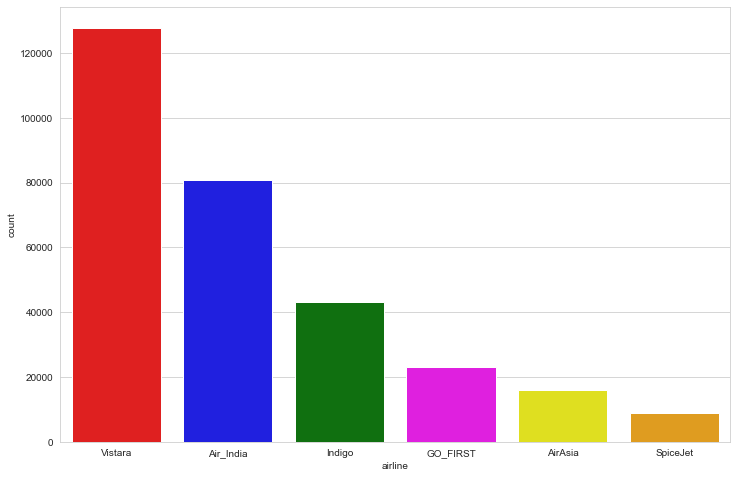

In [21]:
df.groupby('airline').count().withColumnRenamed("count","Count_airline").sort(desc("count")).show()
sns.set_style("whitegrid")
sns.countplot(x="airline", data=df_graph, palette= ["red","blue","green","fuchsia","yellow","orange"],order = df_graph['airline'].value_counts().index)

+-----------+-----------------+
|source_city|Count_source_city|
+-----------+-----------------+
|      Delhi|            61343|
|     Mumbai|            60896|
|  Bangalore|            52061|
|    Kolkata|            46347|
|  Hyderabad|            40806|
|    Chennai|            38700|
+-----------+-----------------+



<AxesSubplot:xlabel='source_city', ylabel='count'>

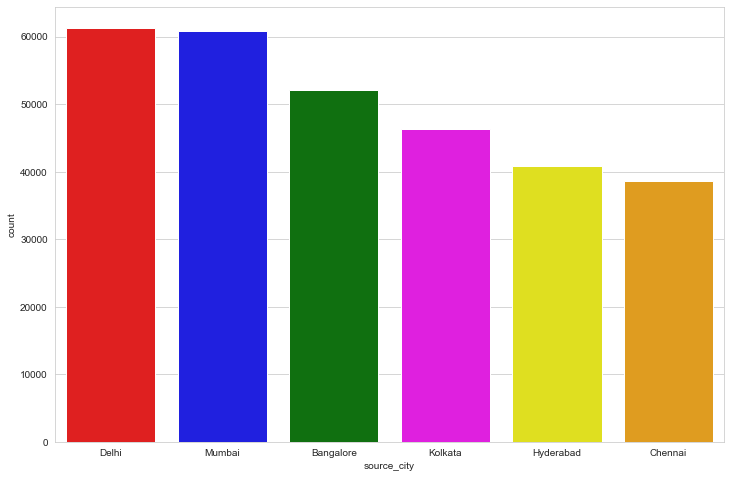

In [22]:
df.groupby('source_city').count().withColumnRenamed("count","Count_source_city").sort(desc("count")).show()
sns.set_style("whitegrid")
sns.countplot(x="source_city", data=df_graph, palette= ["red","blue","green","fuchsia","yellow","orange"],order = df_graph['source_city'].value_counts().index)

+----------------+----------------------+
|destination_city|Count_destination_city|
+----------------+----------------------+
|          Mumbai|                 59097|
|           Delhi|                 57360|
|       Bangalore|                 51068|
|         Kolkata|                 49534|
|       Hyderabad|                 42726|
|         Chennai|                 40368|
+----------------+----------------------+



<AxesSubplot:xlabel='destination_city', ylabel='count'>

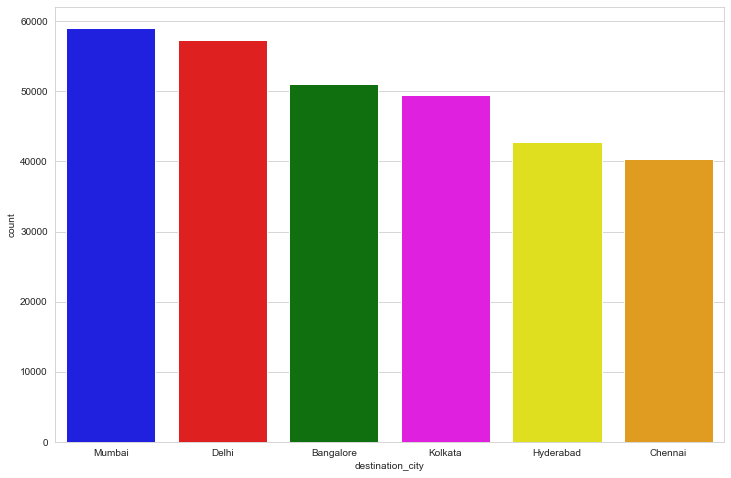

In [23]:
df.groupby('destination_city').count().withColumnRenamed("count","Count_destination_city").sort(desc("count")).show()
sns.countplot(x="destination_city", data=df_graph, palette= ["blue","red","green","fuchsia","yellow","orange"],order = df_graph['destination_city'].value_counts().index)

+--------------+--------------------+
|departure_time|Count_departure_time|
+--------------+--------------------+
|       Morning|               71146|
| Early_Morning|               66790|
|       Evening|               65102|
|         Night|               48015|
|     Afternoon|               47794|
|    Late_Night|                1306|
+--------------+--------------------+



<AxesSubplot:xlabel='departure_time', ylabel='count'>

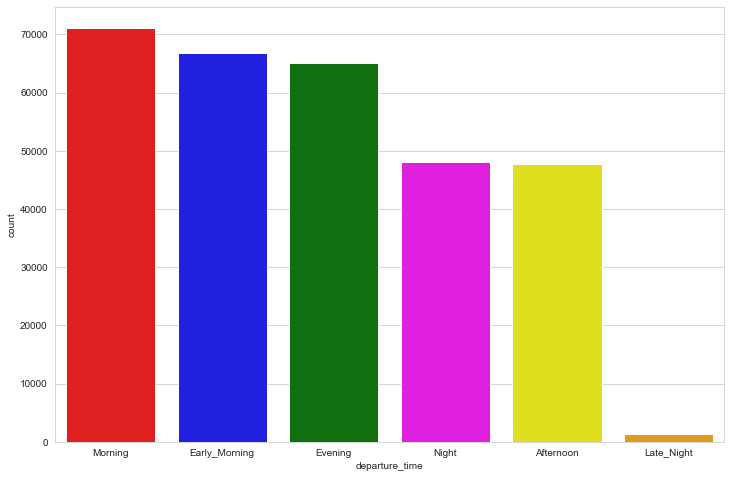

In [24]:
df.groupby('departure_time').count().withColumnRenamed("count","Count_departure_time").sort(desc("count")).show()
sns.set_style("whitegrid")
sns.countplot(x="departure_time", data=df_graph, palette= ["red","blue","green","fuchsia","yellow","orange"],order = df_graph['departure_time'].value_counts().index)

+-------------+------------------+
| arrival_time|Count_arrival_time|
+-------------+------------------+
|        Night|             91538|
|      Evening|             78323|
|      Morning|             62735|
|    Afternoon|             38139|
|Early_Morning|             15417|
|   Late_Night|             14001|
+-------------+------------------+



<AxesSubplot:xlabel='arrival_time', ylabel='count'>

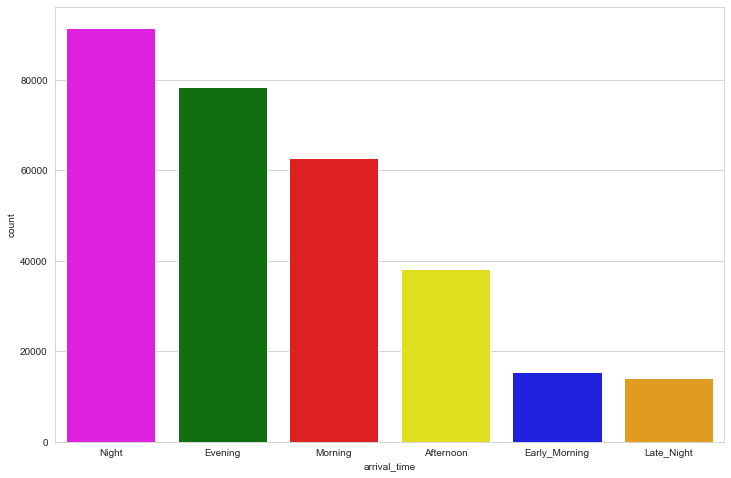

In [25]:
df.groupby('arrival_time').count().withColumnRenamed("count","Count_arrival_time").sort(desc("count")).show()
sns.countplot(x="arrival_time", data=df_graph, palette= ["fuchsia","green","red","yellow","blue","orange"],order = df_graph['arrival_time'].value_counts().index)

+-----------+-----------+
|      stops|Count_stops|
+-----------+-----------+
|        one|     250863|
|       zero|      36004|
|two_or_more|      13286|
+-----------+-----------+



<AxesSubplot:xlabel='stops', ylabel='count'>

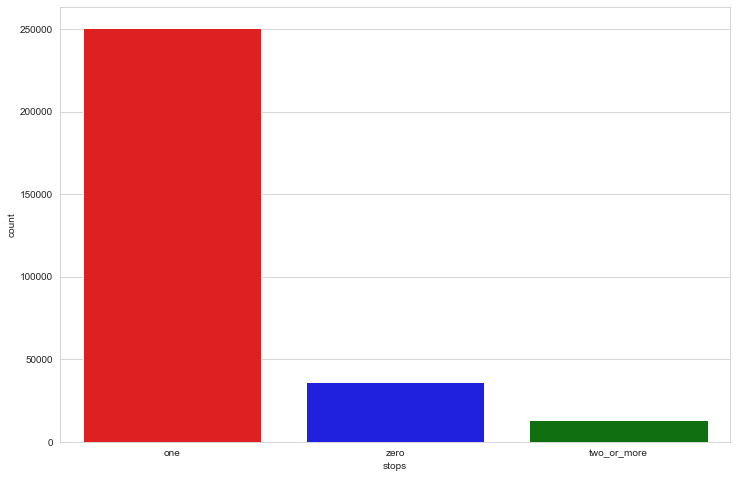

In [26]:
df.groupby('stops').count().withColumnRenamed("count","Count_stops").sort(desc("count")).show()
sns.set_style("whitegrid")
sns.countplot(x="stops", data=df_graph, palette= ["red","blue","green"],order = df_graph['stops'].value_counts().index)

+--------+-----------+
|   class|Count_class|
+--------+-----------+
| Economy|     206666|
|Business|      93487|
+--------+-----------+



<AxesSubplot:xlabel='class', ylabel='count'>

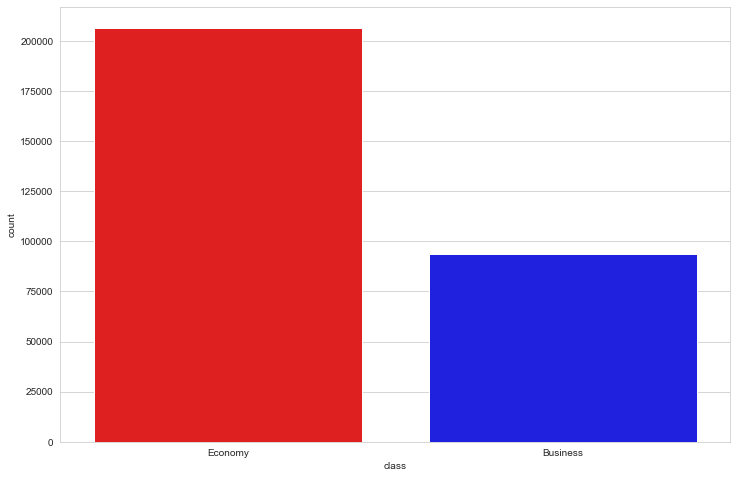

In [27]:
df.groupby('class').count().withColumnRenamed("count","Count_class").sort(desc("count")).show()
sns.countplot(x="class", data=df_graph, palette= ["red","blue"],order = df_graph['class'].value_counts().index)

## Histograms of Quantitative Variables

+--------+--------------+
|duration|Count_duration|
+--------+--------------+
|       2|         20820|
|       7|         17741|
|      12|         17644|
|       8|         17525|
|       6|         17465|
|      10|         17193|
|      11|         17022|
|       9|         16007|
|      13|         15861|
|      14|         14968|
|      15|         13740|
|      16|         12203|
|       3|         11487|
|       5|         11376|
|      17|          8673|
|      24|          6884|
|      26|          6870|
|      22|          6689|
|      25|          6367|
|      23|          6212|
+--------+--------------+
only showing top 20 rows



<AxesSubplot:xlabel='duration', ylabel='Count'>

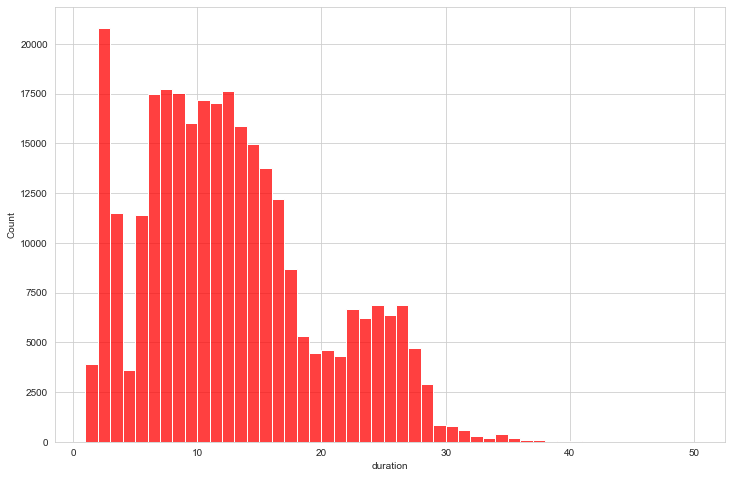

In [28]:
df.groupby('duration').count().withColumnRenamed("count","Count_duration").sort(desc("count")).show()
sns.histplot(data=df_graph, x="duration", color="red",binwidth=1)

[Text(0.5, 1.0, 'Boxplot Duration')]

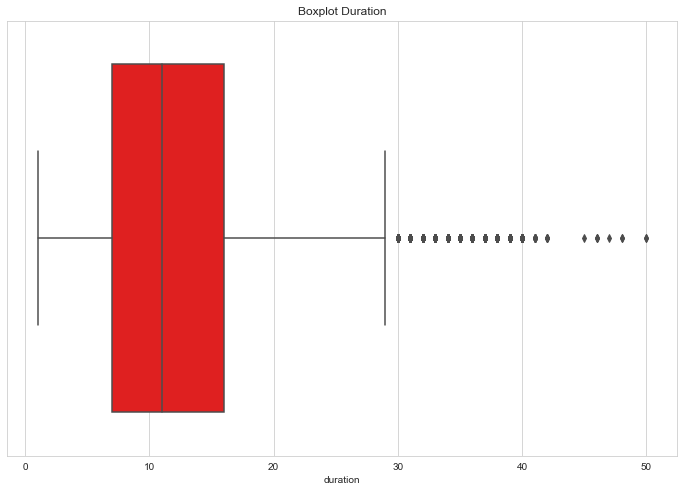

In [29]:
sns.boxplot(x="duration", data=df_graph,color="red").set(title="Boxplot Duration")

In [30]:
df.select("duration").where(df.duration > 40).count()

24

0

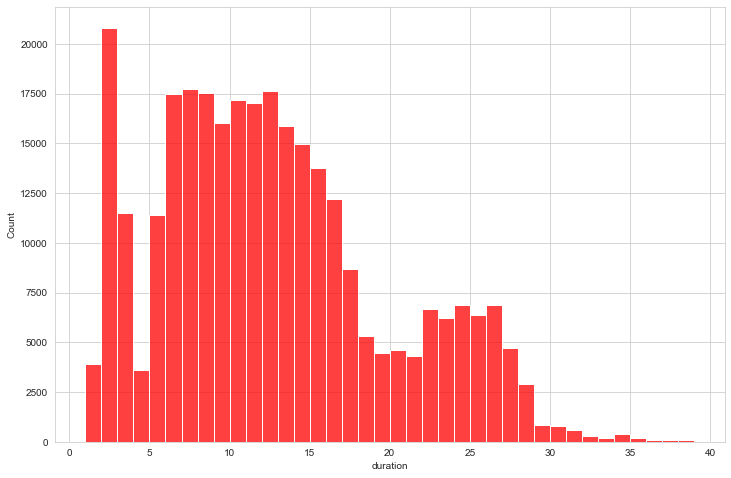

In [31]:
df = df.where(df.duration < 40)
df_graph = df.toPandas()
sns.histplot(data=df_graph, x="duration", color="red",binwidth=1)
df.select("duration").where(df.duration > 40).count()

[Text(0.5, 1.0, 'Boxplot Duration')]

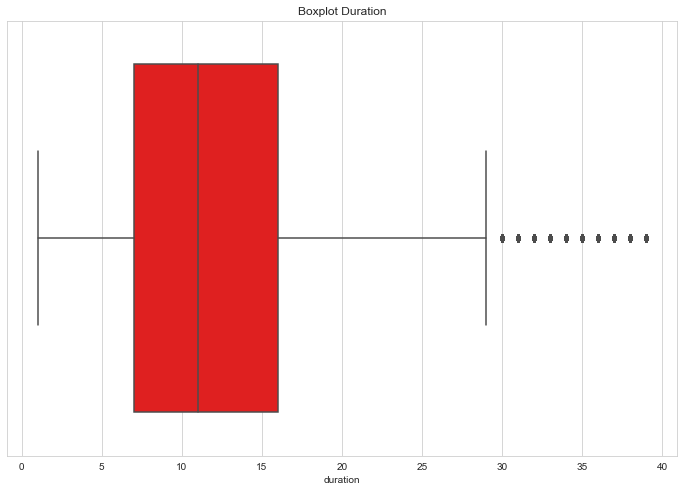

In [32]:
sns.boxplot(x="duration", data=df_graph,color="red").set(title="Boxplot Duration")

+---------+---------------+
|days_left|Count_days_left|
+---------+---------------+
|       25|           6633|
|       18|           6602|
|       39|           6593|
|       32|           6585|
|       26|           6573|
|       24|           6541|
|       19|           6537|
|       31|           6534|
|       33|           6532|
|       40|           6531|
|       41|           6524|
|       28|           6520|
|       38|           6511|
|       20|           6501|
|       30|           6501|
|       42|           6495|
|       22|           6493|
|       36|           6490|
|       21|           6477|
|       37|           6476|
|       43|           6472|
|       44|           6435|
|       17|           6417|
|       11|           6415|
|       34|           6411|
|       13|           6402|
|       23|           6401|
|       29|           6396|
|       12|           6381|
|       27|           6359|
|       14|           6345|
|       15|           6338|
|       45|         

<AxesSubplot:xlabel='days_left', ylabel='Count'>

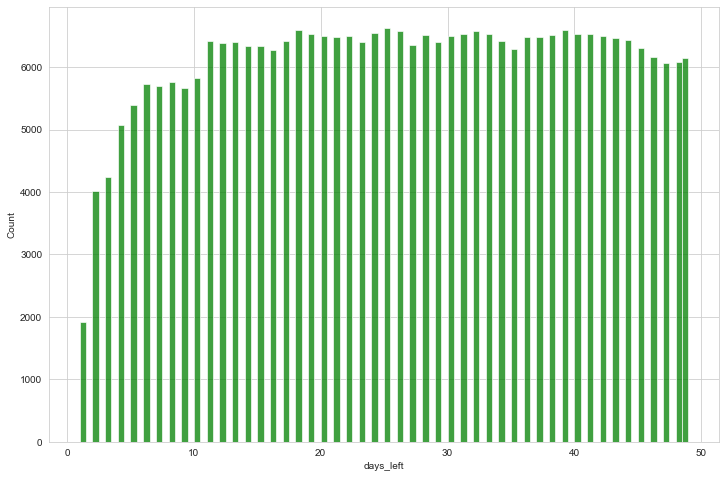

In [33]:
df.groupby('days_left').count().withColumnRenamed("count","Count_days_left").sort(desc("count")).show(50)
sns.histplot(data=df_graph, x="days_left",color="green",binwidth=0.5)

[Text(0.5, 1.0, 'Boxplot Days_left')]

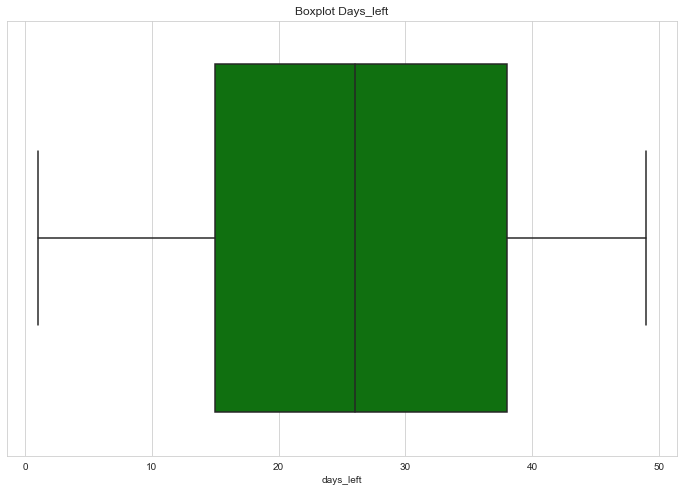

In [34]:
sns.boxplot(x="days_left", data=df_graph,color="green").set(title="Boxplot Days_left")

+----------+----------------+
|Price_in_K|Count_Price_in_K|
+----------+----------------+
|         6|           38102|
|         4|           32587|
|         5|           30562|
|         7|           17980|
|         2|           16445|
|         3|           16130|
|         8|           11305|
|        11|            7602|
|        52|            6517|
|        10|            6468|
|         9|            6420|
|        12|            6077|
|        55|            5795|
|        50|            5147|
|        57|            4371|
|        13|            4116|
|        60|            3858|
|        61|            3634|
|        14|            3429|
|        58|            3289|
+----------+----------------+
only showing top 20 rows



<AxesSubplot:xlabel='Price_in_K', ylabel='Count'>

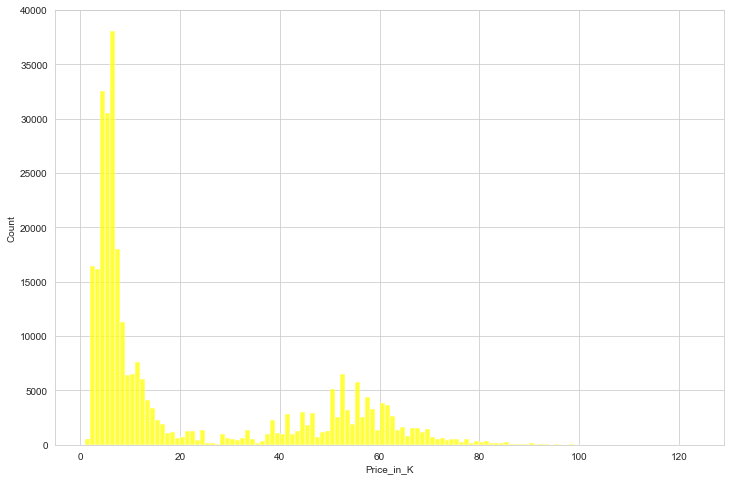

In [35]:
df.groupby("Price_in_K").count().withColumnRenamed("count","Count_Price_in_K").sort(desc("count")).show()
sns.histplot(data=df_graph, x="Price_in_K",color="yellow",binwidth=1)

[Text(0.5, 1.0, 'Price_in_K')]

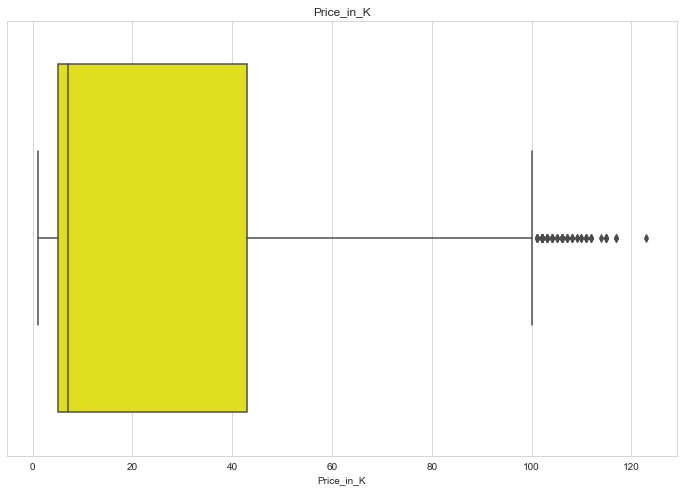

In [36]:
sns.boxplot(x="Price_in_K", data=df_graph,color="yellow").set(title="Price_in_K")

In [37]:
df.select("Price_in_K").where(df.Price_in_K > 100).count()

99

0

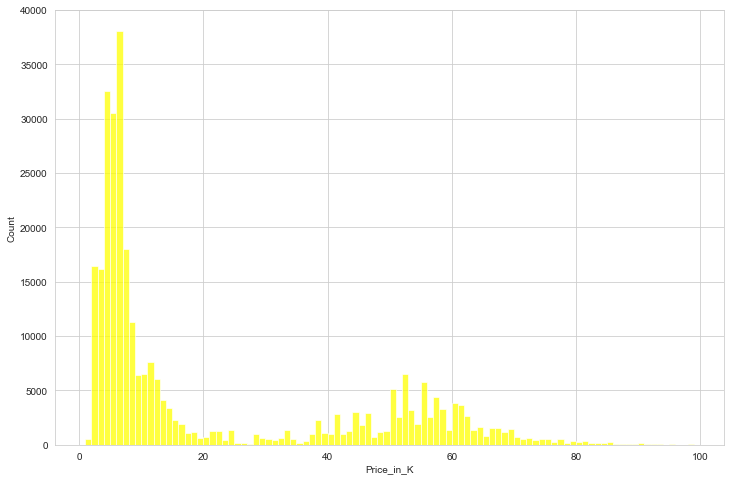

In [38]:
df = df.where(df.Price_in_K < 100)
df_graph = df.toPandas()
sns.histplot(data=df_graph, x="Price_in_K", color="yellow",binwidth=1)
df.select("Price_in_K").where(df.duration > 100).count()

[Text(0.5, 1.0, 'Price_in_K')]

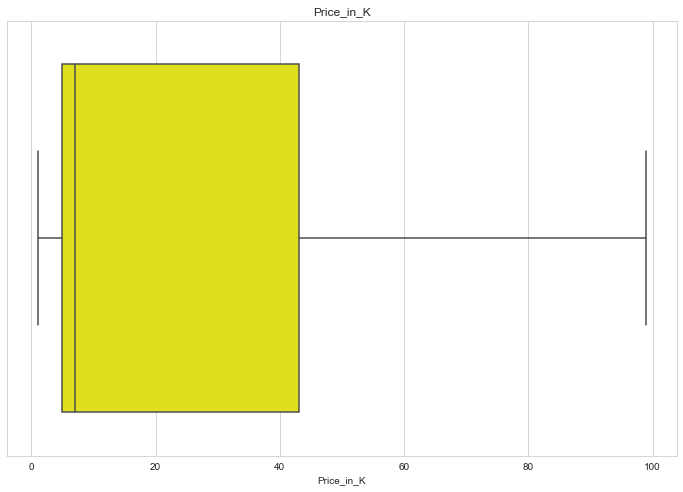

In [39]:
sns.boxplot(x="Price_in_K", data=df_graph,color="yellow").set(title="Price_in_K")

## Graphs of Independent Variables versus Price

[Text(0.5, 1.0, 'Rapporto Prezzo/Airline')]

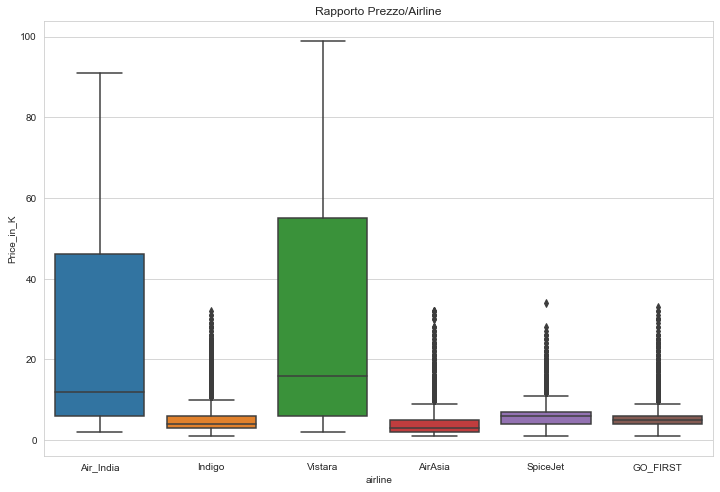

In [40]:
sns.boxplot(x="airline", y="Price_in_K", data=df_graph).set(title="Rapporto Prezzo/Airline")

[Text(0.5, 1.0, 'Rapporto Prezzo/Source_City')]

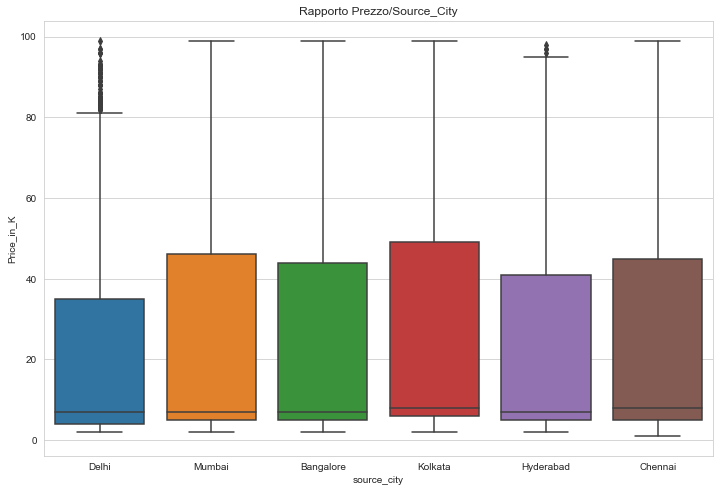

In [41]:
sns.boxplot(x="source_city", y="Price_in_K", data=df_graph).set(title="Rapporto Prezzo/Source_City")

[Text(0.5, 1.0, 'Rapporto Prezzo/Destination_city')]

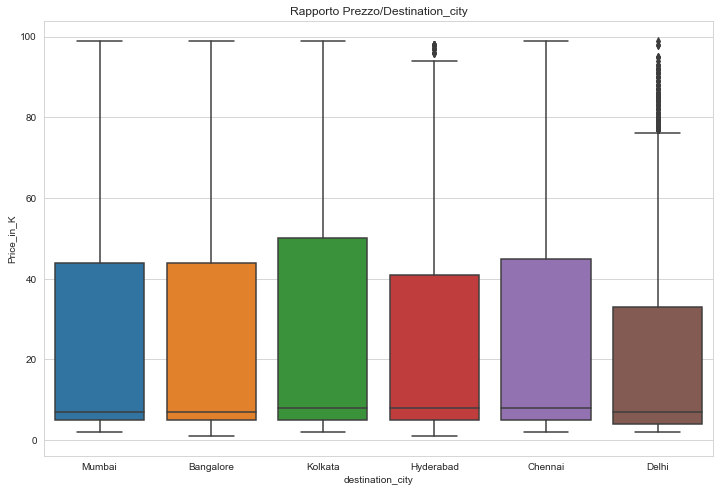

In [42]:
sns.boxplot(x="destination_city", y="Price_in_K", data=df_graph).set(title="Rapporto Prezzo/Destination_city")

[Text(0.5, 1.0, 'Rapporto Prezzo/Departure_Time')]

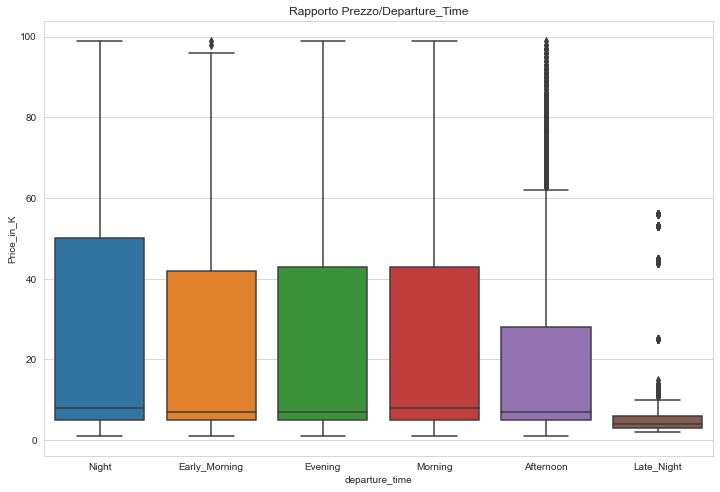

In [43]:
sns.boxplot(x="departure_time", y="Price_in_K", data=df_graph).set(title="Rapporto Prezzo/Departure_Time")

[Text(0.5, 1.0, 'Rapporto Prezzo/Arrival_Time')]

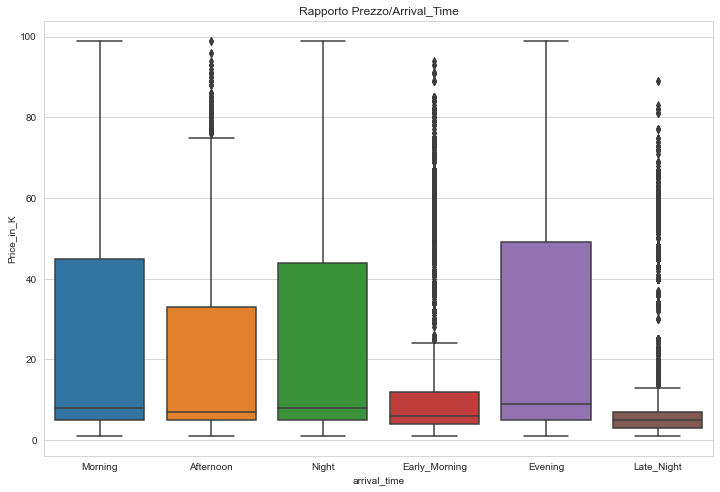

In [44]:
sns.boxplot(x="arrival_time", y="Price_in_K", data=df_graph).set(title="Rapporto Prezzo/Arrival_Time")

[Text(0.5, 1.0, 'Rapporto Prezzo/Stops')]

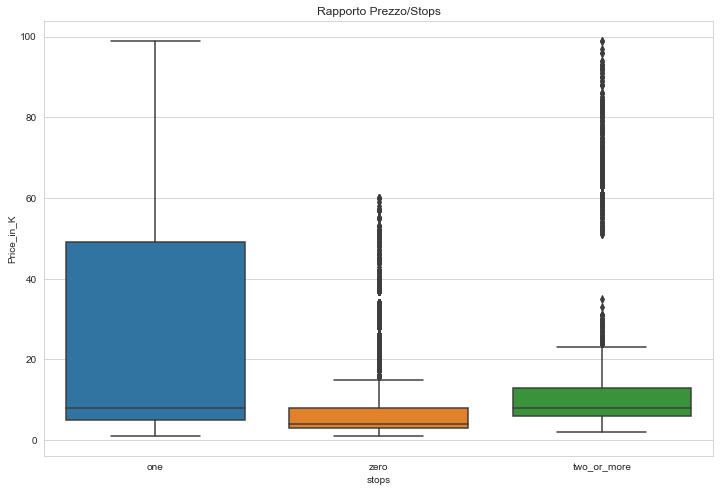

In [45]:
sns.boxplot(x="stops", y="Price_in_K", data=df_graph).set(title="Rapporto Prezzo/Stops")

[Text(0.5, 1.0, 'Rapporto Prezzo/Class')]

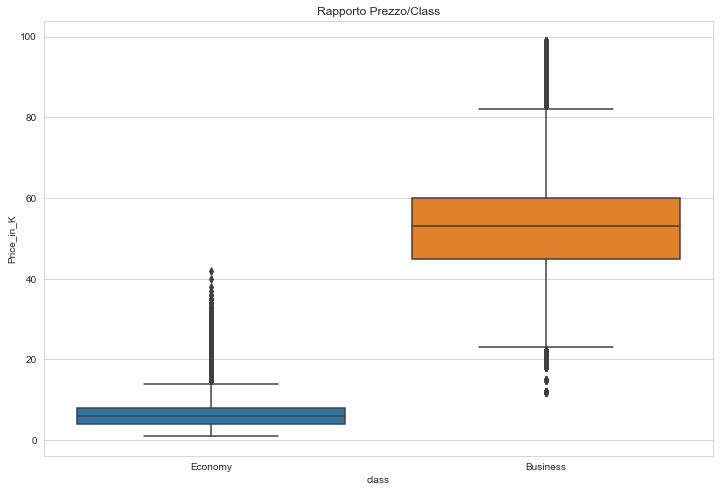

In [46]:
sns.boxplot(x="class", y="Price_in_K", data=df_graph).set(title="Rapporto Prezzo/Class")

[Text(0.5, 1.0, 'Rapporto Prezzo/Duration')]

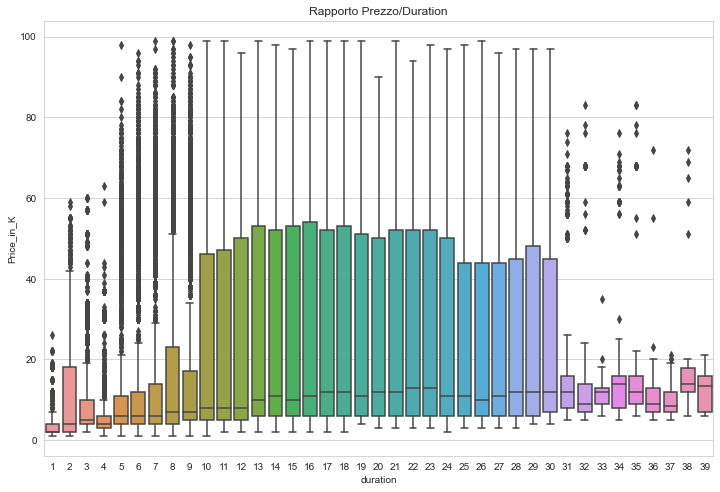

In [47]:
sns.boxplot(x="duration", y="Price_in_K", data=df_graph).set(title="Rapporto Prezzo/Duration")

[Text(0.5, 1.0, 'Rapporto Prezzo/Days_left')]

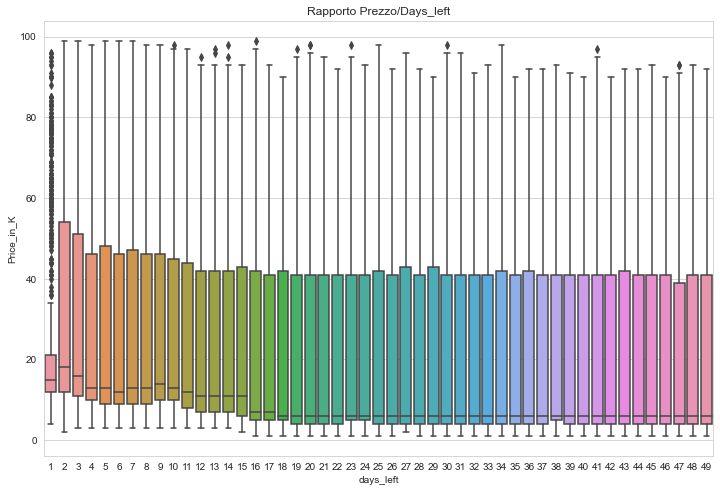

In [48]:
sns.boxplot(x="days_left", y="Price_in_K", data=df_graph).set(title="Rapporto Prezzo/Days_left")

# Data Transformation :

## Scaling of Quantitative Variables

In [49]:
df.printSchema()

root
 |-- airline: string (nullable = true)
 |-- source_city: string (nullable = true)
 |-- departure_time: string (nullable = true)
 |-- stops: string (nullable = true)
 |-- arrival_time: string (nullable = true)
 |-- destination_city: string (nullable = true)
 |-- class: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- days_left: integer (nullable = true)
 |-- Price_in_K: integer (nullable = true)



In [50]:
#Presenza di Outliers e Distribuzione Non Normale = RobustScaler
assemblers1 =  [VectorAssembler(inputCols=["duration"], outputCol="duration_vec")]

In [51]:
robust_scaler = [RobustScaler(inputCol="duration_vec", outputCol="duration_robust")]
pipeline = Pipeline(stages=assemblers1+robust_scaler)
pipe = pipeline.fit(df)
scaled = pipe.transform(df)
scaled.show()

+---------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+----------+------------+--------------------+
|  airline|source_city|departure_time|stops| arrival_time|destination_city|  class|duration|days_left|Price_in_K|duration_vec|     duration_robust|
+---------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+----------+------------+--------------------+
|Air_India|      Delhi|         Night|  one|      Morning|          Mumbai|Economy|      11|        3|        12|      [11.0]| [1.222222222222222]|
|Air_India|      Delhi| Early_Morning|  one|    Afternoon|          Mumbai|Economy|       9|        4|        12|       [9.0]|               [1.0]|
|   Indigo|      Delhi|       Evening| zero|        Night|          Mumbai|Economy|       2|        7|         6|       [2.0]|[0.2222222222222222]|
|   Indigo|      Delhi|       Morning| zero|      Morning|          Mumbai|Economy|       2|        7|         7

In [52]:
#Assenza di Outliers e Distribuzione Non Normale = MinMaxScaling
assemblers2 =  [VectorAssembler(inputCols=["days_left"], outputCol="days_left_vec")]

In [53]:
minmax_scaler = [MinMaxScaler(inputCol="days_left_vec", outputCol="days_left_minmax")]
pipeline = Pipeline(stages=assemblers1+assemblers2+robust_scaler+minmax_scaler)
pipe = pipeline.fit(df)
scaled_df = pipe.transform(df)
scaled_df.show()

+---------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+----------+------------+-------------+--------------------+--------------------+
|  airline|source_city|departure_time|stops| arrival_time|destination_city|  class|duration|days_left|Price_in_K|duration_vec|days_left_vec|     duration_robust|    days_left_minmax|
+---------+-----------+--------------+-----+-------------+----------------+-------+--------+---------+----------+------------+-------------+--------------------+--------------------+
|Air_India|      Delhi|         Night|  one|      Morning|          Mumbai|Economy|      11|        3|        12|      [11.0]|        [3.0]| [1.222222222222222]|[0.04166666666666...|
|Air_India|      Delhi| Early_Morning|  one|    Afternoon|          Mumbai|Economy|       9|        4|        12|       [9.0]|        [4.0]|               [1.0]|            [0.0625]|
|   Indigo|      Delhi|       Evening| zero|        Night|          Mumbai|Economy|  

In [54]:
scaled_df= scaled_df.drop("duration")
scaled_df=scaled_df.drop("duration_vec")
scaled_df=scaled_df.drop("days_left")
scaled_df=scaled_df.drop("days_left_vec")
scaled_df.show()

+---------+-----------+--------------+-----+-------------+----------------+-------+----------+--------------------+--------------------+
|  airline|source_city|departure_time|stops| arrival_time|destination_city|  class|Price_in_K|     duration_robust|    days_left_minmax|
+---------+-----------+--------------+-----+-------------+----------------+-------+----------+--------------------+--------------------+
|Air_India|      Delhi|         Night|  one|      Morning|          Mumbai|Economy|        12| [1.222222222222222]|[0.04166666666666...|
|Air_India|      Delhi| Early_Morning|  one|    Afternoon|          Mumbai|Economy|        12|               [1.0]|            [0.0625]|
|   Indigo|      Delhi|       Evening| zero|        Night|          Mumbai|Economy|         6|[0.2222222222222222]|             [0.125]|
|   Indigo|      Delhi|       Morning| zero|      Morning|          Mumbai|Economy|         7|[0.2222222222222222]|             [0.125]|
|Air_India|      Delhi|       Morning|  o

## One Hot Encoding of Nominal Qualitative Variables

In [55]:
scaled_df.printSchema()

root
 |-- airline: string (nullable = true)
 |-- source_city: string (nullable = true)
 |-- departure_time: string (nullable = true)
 |-- stops: string (nullable = true)
 |-- arrival_time: string (nullable = true)
 |-- destination_city: string (nullable = true)
 |-- class: string (nullable = true)
 |-- Price_in_K: integer (nullable = true)
 |-- duration_robust: vector (nullable = true)
 |-- days_left_minmax: vector (nullable = true)



In [56]:
indexer = StringIndexer(inputCols=('airline','source_city',"departure_time","stops","arrival_time","destination_city","class"),
                        outputCols=('airlineNDX', 'source_cityNDX',"departure_timeNDX","stopsNDX","arrival_timeNDX","destination_cityNDX","classNDX"))

In [57]:
indexed = indexer.fit(scaled_df).transform(scaled_df)
indexed.show()

+---------+-----------+--------------+-----+-------------+----------------+-------+----------+--------------------+--------------------+----------+--------------+-----------------+--------+---------------+-------------------+--------+
|  airline|source_city|departure_time|stops| arrival_time|destination_city|  class|Price_in_K|     duration_robust|    days_left_minmax|airlineNDX|source_cityNDX|departure_timeNDX|stopsNDX|arrival_timeNDX|destination_cityNDX|classNDX|
+---------+-----------+--------------+-----+-------------+----------------+-------+----------+--------------------+--------------------+----------+--------------+-----------------+--------+---------------+-------------------+--------+
|Air_India|      Delhi|         Night|  one|      Morning|          Mumbai|Economy|        12| [1.222222222222222]|[0.04166666666666...|       1.0|           0.0|              3.0|     0.0|            2.0|                0.0|     0.0|
|Air_India|      Delhi| Early_Morning|  one|    Afternoon|  

In [58]:
encoder = OneHotEncoder(inputCols= ("airlineNDX","source_cityNDX","departure_timeNDX","stopsNDX","arrival_timeNDX","destination_cityNDX","classNDX"),outputCols=('airlineENC','source_cityENC',"departure_timeENC","stopsENC","arrival_timeENC","destination_cityENC","classENC"))

In [59]:
encoded_df = encoder.fit(indexed).transform(indexed)

In [60]:
encoded_df.show()

+---------+-----------+--------------+-----+-------------+----------------+-------+----------+--------------------+--------------------+----------+--------------+-----------------+--------+---------------+-------------------+--------+-------------+--------------+-----------------+-------------+---------------+-------------------+-------------+
|  airline|source_city|departure_time|stops| arrival_time|destination_city|  class|Price_in_K|     duration_robust|    days_left_minmax|airlineNDX|source_cityNDX|departure_timeNDX|stopsNDX|arrival_timeNDX|destination_cityNDX|classNDX|   airlineENC|source_cityENC|departure_timeENC|     stopsENC|arrival_timeENC|destination_cityENC|     classENC|
+---------+-----------+--------------+-----+-------------+----------------+-------+----------+--------------------+--------------------+----------+--------------+-----------------+--------+---------------+-------------------+--------+-------------+--------------+-----------------+-------------+-------------

In [61]:
encoded_df.printSchema()

root
 |-- airline: string (nullable = true)
 |-- source_city: string (nullable = true)
 |-- departure_time: string (nullable = true)
 |-- stops: string (nullable = true)
 |-- arrival_time: string (nullable = true)
 |-- destination_city: string (nullable = true)
 |-- class: string (nullable = true)
 |-- Price_in_K: integer (nullable = true)
 |-- duration_robust: vector (nullable = true)
 |-- days_left_minmax: vector (nullable = true)
 |-- airlineNDX: double (nullable = false)
 |-- source_cityNDX: double (nullable = false)
 |-- departure_timeNDX: double (nullable = false)
 |-- stopsNDX: double (nullable = false)
 |-- arrival_timeNDX: double (nullable = false)
 |-- destination_cityNDX: double (nullable = false)
 |-- classNDX: double (nullable = false)
 |-- airlineENC: vector (nullable = true)
 |-- source_cityENC: vector (nullable = true)
 |-- departure_timeENC: vector (nullable = true)
 |-- stopsENC: vector (nullable = true)
 |-- arrival_timeENC: vector (nullable = true)
 |-- destination_

In [62]:
enc_clean_df=encoded_df.drop("airline","source_city","departure_time","stops","arrival_time","destination_city","class")

In [63]:
clean_df_enc=enc_clean_df.drop("airlineNDX","source_cityNDX","departure_timeNDX","stopsNDX","arrival_timeNDX","destination_cityNDX","classNDX")
clean_df_enc.printSchema()
clean_df_enc.show()

root
 |-- Price_in_K: integer (nullable = true)
 |-- duration_robust: vector (nullable = true)
 |-- days_left_minmax: vector (nullable = true)
 |-- airlineENC: vector (nullable = true)
 |-- source_cityENC: vector (nullable = true)
 |-- departure_timeENC: vector (nullable = true)
 |-- stopsENC: vector (nullable = true)
 |-- arrival_timeENC: vector (nullable = true)
 |-- destination_cityENC: vector (nullable = true)
 |-- classENC: vector (nullable = true)

+----------+--------------------+--------------------+-------------+--------------+-----------------+-------------+---------------+-------------------+-------------+
|Price_in_K|     duration_robust|    days_left_minmax|   airlineENC|source_cityENC|departure_timeENC|     stopsENC|arrival_timeENC|destination_cityENC|     classENC|
+----------+--------------------+--------------------+-------------+--------------+-----------------+-------------+---------------+-------------------+-------------+
|        12| [1.222222222222222]|[0.0416666

## Create X (Features) and Y (Target)

In [64]:
regr_assembler = VectorAssembler(inputCols=['duration_robust', 'days_left_minmax', 'airlineENC','source_cityENC','departure_timeENC','stopsENC',"arrival_timeENC","destination_cityENC","classENC"], outputCol='features')

In [65]:
transform=regr_assembler.transform(clean_df_enc)

In [66]:
transform.show()

+----------+--------------------+--------------------+-------------+--------------+-----------------+-------------+---------------+-------------------+-------------+--------------------+
|Price_in_K|     duration_robust|    days_left_minmax|   airlineENC|source_cityENC|departure_timeENC|     stopsENC|arrival_timeENC|destination_cityENC|     classENC|            features|
+----------+--------------------+--------------------+-------------+--------------+-----------------+-------------+---------------+-------------------+-------------+--------------------+
|        12| [1.222222222222222]|[0.04166666666666...|(5,[1],[1.0])| (5,[0],[1.0])|    (5,[3],[1.0])|(2,[0],[1.0])|  (5,[2],[1.0])|      (5,[0],[1.0])|(1,[0],[1.0])|(30,[0,1,3,7,15,1...|
|        12|               [1.0]|            [0.0625]|(5,[1],[1.0])| (5,[0],[1.0])|    (5,[1],[1.0])|(2,[0],[1.0])|  (5,[3],[1.0])|      (5,[0],[1.0])|(1,[0],[1.0])|(30,[0,1,3,7,13,1...|
|         6|[0.2222222222222222]|             [0.125]|(5,[2],[1.0

In [67]:
final_df=transform.select("Price_in_K","features")

In [68]:
final_df.show()

+----------+--------------------+
|Price_in_K|            features|
+----------+--------------------+
|        12|(30,[0,1,3,7,15,1...|
|        12|(30,[0,1,3,7,13,1...|
|         6|(30,[0,1,4,7,14,1...|
|         7|(30,[0,1,4,7,12,1...|
|        15|(30,[0,1,3,7,12,1...|
|         6|(30,[0,1,2,7,14,1...|
|        10|(30,[0,1,6,7,14,1...|
|        11|(30,[0,1,4,7,13,1...|
|         6|(30,[0,1,2,7,16,1...|
|        12|(30,[0,1,2,7,12,1...|
|         3|(30,[0,1,4,7,14,1...|
|         5|(30,[0,1,6,7,14,1...|
|         6|(30,[0,1,2,7,14,1...|
|         3|(30,[0,1,7,14,18,...|
|         2|(30,[0,1,5,7,13,1...|
|         2|(30,[0,1,6,7,15,1...|
|         6|(30,[0,1,2,7,15,1...|
|         4|(30,[0,1,3,7,14,1...|
|        10|(30,[0,1,2,7,14,1...|
|         3|(30,[0,1,2,7,12,1...|
+----------+--------------------+
only showing top 20 rows



# Create Train Set and Test Set

In [69]:
train, test = final_df.randomSplit([0.7,0.3], seed=0)

In [70]:
train.show()

+----------+--------------------+
|Price_in_K|            features|
+----------+--------------------+
|         1|(30,[0,1,4,12,18,...|
|         1|(30,[0,1,4,16,17,...|
|         1|(30,[0,1,4,16,17,...|
|         2|(30,[0,1,2,8,15,1...|
|         2|(30,[0,1,2,8,16,1...|
|         2|(30,[0,1,2,9,12,1...|
|         2|(30,[0,1,3,7,12,1...|
|         2|(30,[0,1,3,7,12,1...|
|         2|(30,[0,1,3,7,12,1...|
|         2|(30,[0,1,3,7,14,1...|
|         2|(30,[0,1,3,8,15,1...|
|         2|(30,[0,1,3,13,18,...|
|         2|(30,[0,1,4,7,14,1...|
|         2|(30,[0,1,4,7,15,1...|
|         2|(30,[0,1,4,7,16,1...|
|         2|(30,[0,1,4,8,13,1...|
|         2|(30,[0,1,4,8,13,1...|
|         2|(30,[0,1,4,8,15,1...|
|         2|(30,[0,1,4,8,15,1...|
|         2|(30,[0,1,4,8,16,1...|
+----------+--------------------+
only showing top 20 rows



## Application of Machine Learning Models:
# Linear Regression
**Y = Price_in_K**
**X = All others Variables**

In [71]:
LR= LinearRegression(featuresCol='features', labelCol='Price_in_K', predictionCol='prediction')

In [72]:
LR_model=LR.fit(train)

In [73]:
test.show()

+----------+--------------------+
|Price_in_K|            features|
+----------+--------------------+
|         1|(30,[0,1,4,12,17,...|
|         1|(30,[0,1,6,15,18,...|
|         2|(30,[0,1,2,9,14,1...|
|         2|(30,[0,1,4,8,14,1...|
|         2|(30,[0,1,4,8,14,1...|
|         2|(30,[0,1,4,11,12,...|
|         2|(30,[0,1,4,11,13,...|
|         2|(30,[0,1,4,11,13,...|
|         2|(30,[0,1,4,11,14,...|
|         2|(30,[0,1,4,12,18,...|
|         2|(30,[0,1,4,14,17,...|
|         2|(30,[0,1,4,15,18,...|
|         2|(30,[0,1,5,7,13,1...|
|         2|(30,[0,1,6,7,12,1...|
|         2|(30,[0,1,6,7,12,1...|
|         2|(30,[0,1,6,7,13,1...|
|         2|(30,[0,1,6,8,12,1...|
|         2|(30,[0,1,6,8,12,1...|
|         2|(30,[0,1,6,8,12,1...|
|         2|(30,[0,1,6,8,15,1...|
+----------+--------------------+
only showing top 20 rows



In [74]:
new_data=test.select("features")

In [75]:
predictions=LR_model.transform(new_data)

In [76]:
predictions.show()

+--------------------+--------------------+
|            features|          prediction|
+--------------------+--------------------+
|(30,[0,1,4,12,17,...|   3.770230545950511|
|(30,[0,1,6,15,18,...| -3.4739603053708734|
|(30,[0,1,2,9,14,1...|  0.9488452420068612|
|(30,[0,1,4,8,14,1...|   5.896723708465451|
|(30,[0,1,4,8,14,1...| -0.5902115743445719|
|(30,[0,1,4,11,12,...|  3.4363238981555355|
|(30,[0,1,4,11,13,...|   4.620664125358367|
|(30,[0,1,4,11,13,...|  3.2464923522671825|
|(30,[0,1,4,11,14,...|  3.8068887067653137|
|(30,[0,1,4,12,18,...| -3.6043612920926833|
|(30,[0,1,4,14,17,...|   7.308672209063737|
|(30,[0,1,4,15,18,...|-0.43656223437546515|
|(30,[0,1,5,7,13,1...|  -4.171779044253974|
|(30,[0,1,6,7,12,1...|  3.1865299862296865|
|(30,[0,1,6,7,12,1...|    3.14609162726196|
|(30,[0,1,6,7,13,1...|   8.441297258165939|
|(30,[0,1,6,8,12,1...|   4.627221309710741|
|(30,[0,1,6,8,12,1...|   4.082263074466688|
|(30,[0,1,6,8,12,1...|   2.152772659608253|
|(30,[0,1,6,8,15,1...|    5.6187

# Final Results:

## Train Results

In [77]:
trainingSummary=LR_model.summary

In [78]:
print("Train Set Results:")
print(f"MAE: {trainingSummary.meanAbsoluteError}")
print(f"RMSE: {trainingSummary.rootMeanSquaredError}")
print(f"R^2 measure: {trainingSummary.r2}")
train.describe().show()

Train Set Results:
MAE: 4.567623477948855
RMSE: 6.704351139160643
R^2 measure: 0.9126143199834577
+-------+------------------+
|summary|        Price_in_K|
+-------+------------------+
|  count|            209833|
|   mean|20.848984668760394|
| stddev|22.679718096967324|
|    min|                 1|
|    max|                99|
+-------+------------------+



## Test Results

In [79]:
test_result= LR_model.evaluate(test)

In [80]:
print("Test Set Results:")
print(f"MAE: {test_result.meanAbsoluteError}")
print(f"RMSE: {test_result.rootMeanSquaredError}")
print(f"R^2 measure: {test_result.r2}")
print(f"R^2adjusted: {test_result.r2adj}")
test.describe().show()

Test Set Results:
MAE: 4.554033585972976
RMSE: 6.6975412145454305
R^2 measure: 0.9125960776751125
R^2adjusted: 0.9125669776310567
+-------+------------------+
|summary|        Price_in_K|
+-------+------------------+
|  count|             90138|
|   mean|20.814062881359693|
| stddev|22.654388432781385|
|    min|                 1|
|    max|                99|
+-------+------------------+



# Second Linear Regression Model
**Y = Price_in_K**
**X = Airline,Class,Duration,Days_left**

In [81]:
clean_df_enc.printSchema()
sec_clean_df_enc = clean_df_enc
sec_clean_df_enc.printSchema()

root
 |-- Price_in_K: integer (nullable = true)
 |-- duration_robust: vector (nullable = true)
 |-- days_left_minmax: vector (nullable = true)
 |-- airlineENC: vector (nullable = true)
 |-- source_cityENC: vector (nullable = true)
 |-- departure_timeENC: vector (nullable = true)
 |-- stopsENC: vector (nullable = true)
 |-- arrival_timeENC: vector (nullable = true)
 |-- destination_cityENC: vector (nullable = true)
 |-- classENC: vector (nullable = true)

root
 |-- Price_in_K: integer (nullable = true)
 |-- duration_robust: vector (nullable = true)
 |-- days_left_minmax: vector (nullable = true)
 |-- airlineENC: vector (nullable = true)
 |-- source_cityENC: vector (nullable = true)
 |-- departure_timeENC: vector (nullable = true)
 |-- stopsENC: vector (nullable = true)
 |-- arrival_timeENC: vector (nullable = true)
 |-- destination_cityENC: vector (nullable = true)
 |-- classENC: vector (nullable = true)



In [82]:
sec_regr_assembler = VectorAssembler(inputCols=["airlineENC","classENC","duration_robust","days_left_minmax"], outputCol='sec_features')

In [83]:
sec_transform=sec_regr_assembler.transform(sec_clean_df_enc)

In [84]:
sec_final_df=sec_transform.select("Price_in_K","sec_features")

In [85]:
sec_final_df.show()

+----------+--------------------+
|Price_in_K|        sec_features|
+----------+--------------------+
|        12|(8,[1,5,6,7],[1.0...|
|        12|(8,[1,5,6,7],[1.0...|
|         6|(8,[2,5,6,7],[1.0...|
|         7|(8,[2,5,6,7],[1.0...|
|        15|(8,[1,5,6,7],[1.0...|
|         6|(8,[0,5,6,7],[1.0...|
|        10|(8,[4,5,6,7],[1.0...|
|        11|(8,[2,5,6,7],[1.0...|
|         6|(8,[0,5,6,7],[1.0...|
|        12|(8,[0,5,6,7],[1.0...|
|         3|(8,[2,5,6,7],[1.0...|
|         5|(8,[4,5,6,7],[1.0...|
|         6|(8,[0,5,6,7],[1.0...|
|         3|(8,[5,6,7],[1.0,0...|
|         2|(8,[3,5,6,7],[1.0...|
|         2|(8,[4,5,6,7],[1.0...|
|         6|(8,[0,5,6,7],[1.0...|
|         4|(8,[1,5,6,7],[1.0...|
|        10|(8,[0,5,6,7],[1.0...|
|         3|(8,[0,5,6,7],[1.0...|
+----------+--------------------+
only showing top 20 rows



In [86]:
sec_train, sec_test = sec_final_df.randomSplit([0.7,0.3], seed=0)

In [87]:
sec_LR = LinearRegression(featuresCol='sec_features', labelCol='Price_in_K', predictionCol='prediction')
sec_LR_model = sec_LR.fit(sec_train)

In [88]:
sec_new_data = sec_test.select("sec_features")
sec_predictions = sec_LR_model.transform(sec_new_data)

In [89]:
sec_trainingSummary = sec_LR_model.summary
print("Second Train Set Results:")
print(f"MAE: {sec_trainingSummary.meanAbsoluteError}")
print(f"RMSE: {sec_trainingSummary.rootMeanSquaredError}")
print(f"R^2 measure: {sec_trainingSummary.r2}")
sec_train.describe().show()

Second Train Set Results:
MAE: 4.489467457047102
RMSE: 7.203431957046782
R^2 measure: 0.8991198586717164
+-------+------------------+
|summary|        Price_in_K|
+-------+------------------+
|  count|            209833|
|   mean|20.848984668760394|
| stddev|22.679718096967324|
|    min|                 1|
|    max|                99|
+-------+------------------+



In [90]:
sec_test_result = sec_LR_model.evaluate(sec_test)
print("Second Test Set Results:")
print(f"MAE: {sec_test_result.meanAbsoluteError}")
print(f"RMSE: {sec_test_result.rootMeanSquaredError}")
print(f"R^2 measure: {sec_test_result.r2}")
print(f"R^2adjusted: {sec_test_result.r2adj}")
sec_test.describe().show()

Second Test Set Results:
MAE: 4.498806377890135
RMSE: 7.208868773535858
R^2 measure: 0.8987408278051601
R^2adjusted: 0.8987318398725572
+-------+------------------+
|summary|        Price_in_K|
+-------+------------------+
|  count|             90138|
|   mean|20.814062881359693|
| stddev|22.654388432781385|
|    min|                 1|
|    max|                99|
+-------+------------------+



# Third Linear Regression Model
**Y = Price_in_K**
**X = Class**

In [91]:
clean_df_enc.printSchema()
third_clean_df_enc = clean_df_enc
third_clean_df_enc.printSchema()

root
 |-- Price_in_K: integer (nullable = true)
 |-- duration_robust: vector (nullable = true)
 |-- days_left_minmax: vector (nullable = true)
 |-- airlineENC: vector (nullable = true)
 |-- source_cityENC: vector (nullable = true)
 |-- departure_timeENC: vector (nullable = true)
 |-- stopsENC: vector (nullable = true)
 |-- arrival_timeENC: vector (nullable = true)
 |-- destination_cityENC: vector (nullable = true)
 |-- classENC: vector (nullable = true)

root
 |-- Price_in_K: integer (nullable = true)
 |-- duration_robust: vector (nullable = true)
 |-- days_left_minmax: vector (nullable = true)
 |-- airlineENC: vector (nullable = true)
 |-- source_cityENC: vector (nullable = true)
 |-- departure_timeENC: vector (nullable = true)
 |-- stopsENC: vector (nullable = true)
 |-- arrival_timeENC: vector (nullable = true)
 |-- destination_cityENC: vector (nullable = true)
 |-- classENC: vector (nullable = true)



In [92]:
third_regr_assembler = VectorAssembler(inputCols=["classENC"], outputCol='third_features')
third_transform = third_regr_assembler.transform(third_clean_df_enc)
third_final_df = third_transform.select("Price_in_K", "third_features")
third_final_df.show()

+----------+--------------+
|Price_in_K|third_features|
+----------+--------------+
|        12|         [1.0]|
|        12|         [1.0]|
|         6|         [1.0]|
|         7|         [1.0]|
|        15|         [1.0]|
|         6|         [1.0]|
|        10|         [1.0]|
|        11|         [1.0]|
|         6|         [1.0]|
|        12|         [1.0]|
|         3|         [1.0]|
|         5|         [1.0]|
|         6|         [1.0]|
|         3|         [1.0]|
|         2|         [1.0]|
|         2|         [1.0]|
|         6|         [1.0]|
|         4|         [1.0]|
|        10|         [1.0]|
|         3|         [1.0]|
+----------+--------------+
only showing top 20 rows



In [93]:
third_train, third_test = third_final_df.randomSplit([0.7, 0.3], seed=0)
third_LR = LinearRegression(featuresCol='third_features', labelCol='Price_in_K', predictionCol='prediction')
third_LR_model = third_LR.fit(third_train)
third_new_data = third_test.select("third_features")
third_predictions = third_LR_model.transform(third_new_data)

In [94]:
third_trainingSummary = third_LR_model.summary
print("Third Train Set Results:")
print(f"MAE: {third_trainingSummary.meanAbsoluteError}")
print(f"RMSE: {third_trainingSummary.rootMeanSquaredError}")
print(f"R^2 measure: {third_trainingSummary.r2}")
third_train.describe().show()

Third Train Set Results:
MAE: 4.905741493355071
RMSE: 7.824139123329373
R^2 measure: 0.8809854952106777
+-------+------------------+
|summary|        Price_in_K|
+-------+------------------+
|  count|            209833|
|   mean|20.848984668760394|
| stddev|22.679718096967324|
|    min|                 1|
|    max|                99|
+-------+------------------+



In [95]:
third_test_result = third_LR_model.evaluate(third_test)
print("Third Test Set Results:")
print(f"MAE: {third_test_result.meanAbsoluteError}")
print(f"RMSE: {third_test_result.rootMeanSquaredError}")
print(f"R^2 measure: {third_test_result.r2}")
print(f"R^2adjusted: {third_test_result.r2adj}")
third_test.describe().show()

Third Test Set Results:
MAE: 4.90260192542796
RMSE: 7.807911687889104
R^2 measure: 0.8812127254747689
R^2adjusted: 0.8812114076076067
+-------+------------------+
|summary|        Price_in_K|
+-------+------------------+
|  count|             90138|
|   mean|20.814062881359693|
| stddev|22.654388432781385|
|    min|                 1|
|    max|                99|
+-------+------------------+



# Close Spark Session

In [96]:
spark.stop()